# Propogating geometric information: $k$-chains

*Background:*
In geometric GNNs, **geometric information**, such as the relative orientation of local neighbourhoods, is propogated via summing features from multiple layers in fixed dimensional spaces. 
The ideal architecture can be run for any number of layers to perfectly propogate geometric information without loss of information.
In practice, stacking geometric GNN layers may lead to distortion or **loss of information from distant nodes**.

*Experiment:*
To study the practical implications of depth in propagating geometric information beyond local neighbourhoods, we consider **$k$-chain geometric graphs** which generalise the examples from [Schütt et al., 2021](https://arxiv.org/abs/2102.03150). 
Each pair of $k$-chains consists of $k+2$ nodes with $k$ nodes arranged in a line and differentiated by the orientation of the $2$ end points.
Thus, $k$-chain graphs are $(\lfloor \frac{k}{2} \rfloor + 1)$-hop distinguishable, and $(\lfloor \frac{k}{2} \rfloor + 1)$ geometric GNN iterations should be theoretically sufficient to distinguish them.
In this notebook, we train equivariant and invariant geometric GNNs with an increasing number of layers to distinguish $k$-chains.

![k-chains](fig/kchains.png)

*Results:*
- Despite the supposed simplicity of the task, especially for small chain lengths, we find that popular equivariant GNNs such as E-GNN and TFN may require **more iterations** than theoretically sufficient.
- Notably, as the length of the chain gets larger than $k=4$, all equivariant GNNs tended to lose performance and required more than $(\lfloor \frac{k}{2} \rfloor + 1)$ iterations to solve the task.
- Invariant GNNs are **unable** to distinguish $k$-chains.

These results points to preliminary evidence of the **oversquashing** phenomenon for geometric GNNs.
These issues are most evident for E-GNN, which uses a single vector feature to aggregate and propogate geometric information.

In [5]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import random
import numpy as np
import torch
from torch.nn import functional as F
import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import is_undirected, to_undirected, remove_self_loops, to_dense_adj, dense_to_sparse
import e3nn
from e3nn import o3
from functools import partial

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))
print("e3nn version {}".format(e3nn.__version__))

from src.utils.plot_utils import plot_2d, plot_3d
from src.utils.train_utils import run_experiment
from src.models import MPNNModel, EGNNModel, GVPGNNModel, TFNModel, SchNetModel, DimeNetPPModel, MACEModel

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
# print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
# print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version 1.12.1
PyG version 2.1.0
e3nn version 0.4.4
Using device: cpu


In [2]:
def create_kchains(k):
    assert k >= 2
    
    dataset = []

    # Graph 0
    atoms = torch.LongTensor( [0] + [0] + [0]*(k-1) + [0] )
    edge_index = torch.LongTensor( [ [i for i in range((k+2) - 1)], [i for i in range(1, k+2)] ] )
    pos = torch.FloatTensor(
        [[-4, -3, 0]] + 
        [[0, 5*i , 0] for i in range(k)] + 
        [[4, 5*(k-1) + 3, 0]]
    )
    center_of_mass = torch.mean(pos, dim=0)
    pos = pos - center_of_mass
    y = torch.LongTensor([0])  # Label 0
    data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data1.edge_index = to_undirected(data1.edge_index)
    dataset.append(data1)
    
    # Graph 1
    atoms = torch.LongTensor( [0] + [0] + [0]*(k-1) + [0] )
    edge_index = torch.LongTensor( [ [i for i in range((k+2) - 1)], [i for i in range(1, k+2)] ] )
    pos = torch.FloatTensor(
        [[4, -3, 0]] + 
        [[0, 5*i , 0] for i in range(k)] + 
        [[4, 5*(k-1) + 3, 0]]
    )
    center_of_mass = torch.mean(pos, dim=0)
    pos = pos - center_of_mass
    y = torch.LongTensor([1])  # Label 1
    data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data2.edge_index = to_undirected(data2.edge_index)
    dataset.append(data2)
    
    return dataset

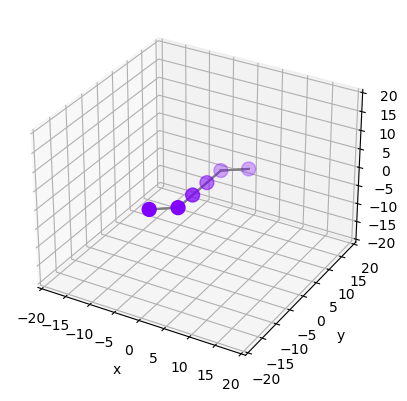

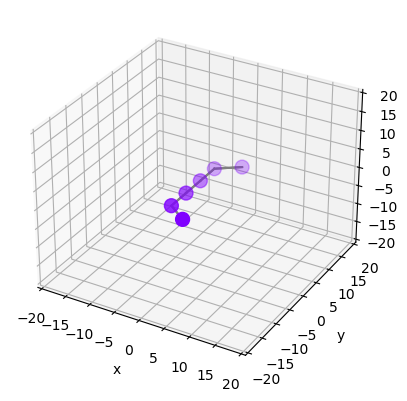

In [3]:
k = 4

# Create dataset
dataset = create_kchains(k=k)
for data in dataset:
    # plot_2d(data, lim=5*k)
    plot_3d(data, lim=5*k)

In [4]:
# Set model
model_name = "gvp"

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(dataset, batch_size=2, shuffle=False)

for num_layers in range(k // 2 , k + 3):

    print(f"\nNumber of layers: {num_layers}")
    
    model = {
        "mpnn": MPNNModel,
        "schnet": SchNetModel,
        "dimenet": DimeNetPPModel,
        "egnn": EGNNModel,
        "gvp": GVPGNNModel,
        "tfn": TFNModel,
        "mace": partial(MACEModel, correlation=2),
    }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)
    
    best_val_acc, test_acc, train_time = run_experiment(
        model, 
        dataloader,
        val_loader, 
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False
    )


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:34<00:00,  3.43s/it]



Done! Averaged over 10 runs: 
 - Training time: 3.43s ± 0.39. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:17<00:00,  7.72s/it]



Done! Averaged over 10 runs: 
 - Training time: 7.71s ± 2.04. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:13<00:00,  7.36s/it]



Done! Averaged over 10 runs: 
 - Training time: 7.35s ± 0.80. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:16<00:00,  7.68s/it]



Done! Averaged over 10 runs: 
 - Training time: 7.67s ± 0.54. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:24<00:00,  8.40s/it]


Done! Averaged over 10 runs: 
 - Training time: 8.39s ± 0.15. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 

